In [45]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from functools import partial

In [83]:
@partial(jax.jit, static_argnums=(2, 3))
def linear(pos : jax.Array, weight : jax.Array, grid_size : int, dx : float) -> jax.Array:

    coords = jnp.linspace(start=0, stop=1, num=grid_size+1)

    grid = jnp.zeros((grid_size, grid_size, grid_size))

    # find position on the grid
    x_idx = jnp.digitize(pos[0], coords, right=True) - 1
    y_idx = jnp.digitize(pos[1], coords, right=True) - 1
    z_idx = jnp.digitize(pos[2], coords, right=True) - 1

    # assign the mass
    grid = grid.at[x_idx, y_idx, z_idx].set(weight / dx**3)

    return grid

In [84]:
def loss(params, grid_star : jax.Array, dx : float) -> jax.Array:
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
    grid = linear(pos, weight, grid_size, dx)

    loss = jnp.mean((grid - grid_star)**2)
    return loss

In [102]:
def optimize(params, grid_star : jax.Array, dx : float, n_steps : int) -> jax.Array:

    optimizer = optax.adam(1e-5)
    opt_state = optimizer.init(params)

    loss_grad = jax.grad(loss)

    @jax.jit
    def step(params, opt_state):
        grad = loss_grad(params, grid_star, dx)
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    
    for i in range(n_steps):
        params, opt_state = step(params, opt_state)
        # print(loss(params, grid_star, dx))

    return params

In [100]:
N = 1000
grid_size = 10
dx = 0.1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
weight = jax.random.uniform(key_weight, (N,))

# assign particles 
grid_star = linear(pos, weight, grid_size, dx)

print(grid_star.mean())

340.67435


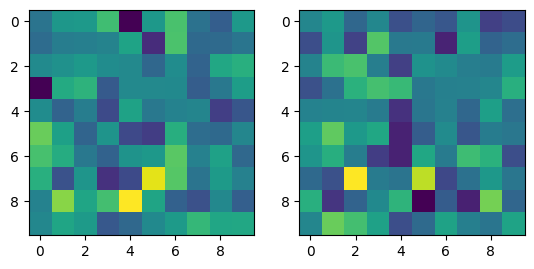

In [103]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

pos = jax.random.uniform(key_pos, (3, N)) 
weight = jax.random.uniform(key_weight, (N, ))

params_init = {
    'pos' : pos,
    'weight' : weight}


params = optimize(params_init, grid_star, dx, 10000)

grid = linear(params["pos"], params["weight"], grid_size, 0.1)

# plot side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grid_star.sum(axis=0))
plt.subplot(1, 2, 2)
plt.imshow(grid.sum(axis=0))
plt.show()

In [91]:
# # cic mass assignment
# def cic(pos : jax.Array, weight : jax.Array, grid_size : int, dx : float) -> jax.Array:

#     coords = jnp.linspace(start=0, stop=1, num=grid_size+1)
#     x, y, z = jnp.meshgrid(coords, coords, coords)

#     grid = jnp.zeros((grid_size, grid_size, grid_size))

#     # find position on the grid
#     x_idx = jnp.digitize(pos[0], coords, right=True) - 1
#     y_idx = jnp.digitize(pos[1], coords, right=True) - 1
#     z_idx = jnp.digitize(pos[2], coords, right=True) - 1

#     x_cell = coords[x_idx]
#     y_cell = coords[y_idx]
#     z_cell = coords[z_idx]

#     # center values
#     values = (x - x_cell) * (y - y_cell) * (z - z_cell) * weight / dx**3
#     grid = grid.at[x_idx, y_idx, z_idx].set(values)

#     return grid

In [71]:
k1, k2 = jax.random.split(key)
rand = jax.random.uniform(k1, (100, 100, 100))
rand2 = jax.random.uniform(k2, (100, 100, 100))

print(jnp.mean((rand - jnp.zeros((100, 100, 100)))**2))

0.3333149
